Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
!unzip "/content/gdrive/My Drive/CNN_assignment.zip" > /dev/null

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
# Setting the btach size, imahe height and width
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

# Create the training dataset using tf.keras.preprocessing.image_dataset_from_directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,  # Setting seed for reproducibility
    image_size=(img_height, img_width),  # Resize images to specified dimensions
    batch_size=batch_size,
    validation_split=0.2,  # Splitting train dataset into train and validation
    label_mode='categorical',
    subset='training'  # Selecting the training subset
)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
# Printing the class names
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

# Create the validation dataset using tf.keras.preprocessing.image_dataset_from_directory
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,  # Setting seed for reproducibility
    image_size=(img_height, img_width),  # Resize images to specified dimensions
    batch_size=batch_size,
    validation_split=0.2,  # Splitting train dataset into train and validation
    label_mode='categorical',
    subset='validation'  # Selecting the validation subset
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

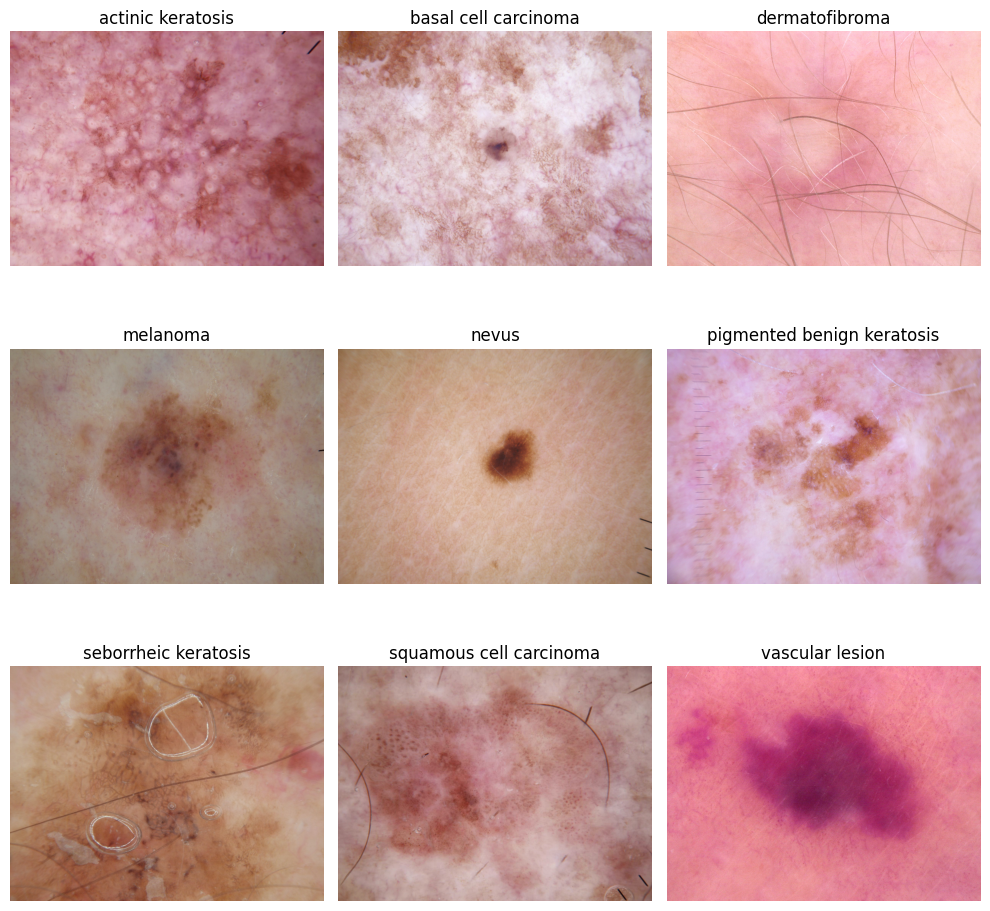

In [11]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
### your code goes here, you can use training or validation data to visualize

class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

# Create a figure with subplots for each class
num_classes = len(class_names)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Loop through each class
for i, class_name in enumerate(class_names):
    # Get a list of image files for the current class
    class_dir = os.path.join(data_dir_train, class_name)
    image_files = os.listdir(class_dir)
    # Select a random image file
    random_image_file = random.choice(image_files)
    # Load and display the image
    image_path = os.path.join(class_dir, random_image_file)
    image = Image.open(image_path)
    row = i // 3
    col = i % 3
    axes[row, col].imshow(image)
    axes[row, col].set_title(class_name)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
# model architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
import tensorflow as tf

input_shape = (180,180,3)
num_classes = 9
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [14]:
## model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                        

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                        

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=batch_size,
  shuffle=True
)


Epoch 1/20
56/56 [==============================] - 27s 164ms/step - loss: 2.3511 - accuracy: 0.1875 - val_loss: 2.0345 - val_accuracy: 0.2125
Epoch 2/20
56/56 [==============================] - 4s 79ms/step - loss: 2.0076 - accuracy: 0.2444 - val_loss: 2.0050 - val_accuracy: 0.2864
Epoch 3/20
56/56 [==============================] - 4s 79ms/step - loss: 1.9452 - accuracy: 0.2991 - val_loss: 2.0274 - val_accuracy: 0.2081
Epoch 4/20
56/56 [==============================] - 4s 78ms/step - loss: 1.8987 - accuracy: 0.2885 - val_loss: 1.9016 - val_accuracy: 0.3154
Epoch 5/20
56/56 [==============================] - 4s 78ms/step - loss: 1.7906 - accuracy: 0.3566 - val_loss: 1.7273 - val_accuracy: 0.3736
Epoch 6/20
56/56 [==============================] - 4s 80ms/step - loss: 1.6406 - accuracy: 0.4269 - val_loss: 1.6282 - val_accuracy: 0.4989
Epoch 7/20
56/56 [==============================] - 4s 78ms/step - loss: 1.5908 - accuracy: 0.4330 - val_loss: 1.6723 - val_accuracy: 0.4922
Epoch 8/20


### Visualizing training results

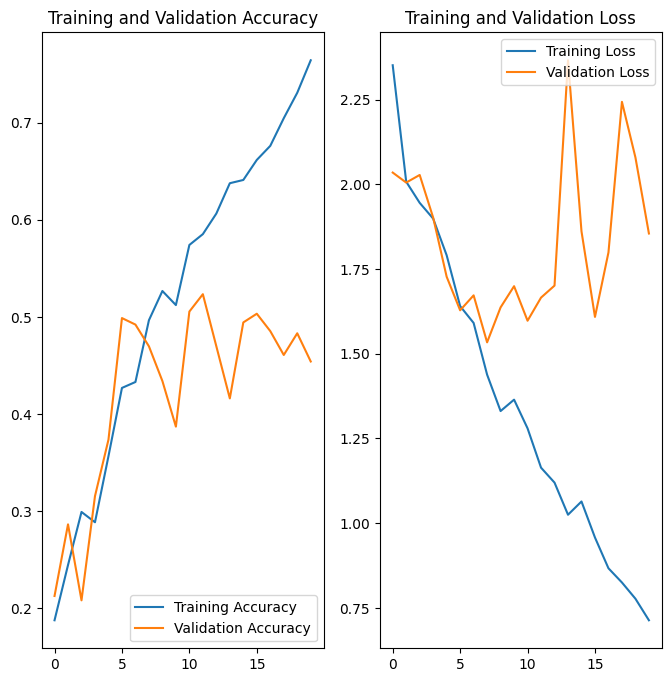

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 19ms/step - loss: 1.8547 - accuracy: 0.4541
Accuracy:  0.7421875
Validation Accuracy:  0.45413869619369507
Loss:  0.7548336982727051
Validation Loss 1.854718565940857


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

### From the training and validation results its observed that model is overfitted

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,          # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,      # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,     # randomly shift images vertically (fraction of total height)
    zoom_range=0.1,             # randomly zoom image
    horizontal_flip=True,       # randomly flip images horizontally
    vertical_flip=False,        # randomly flip images vertically
    fill_mode='nearest',        # strategy used for filling in newly created pixels
    rescale=1./255,             # rescale pixel values to [0, 1]
    featurewise_center=False,   # set input mean to 0 over the dataset
    samplewise_center=False,    # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,   # divide each input by its std
    zca_whitening=False,        # apply ZCA whitening
)


image_class = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

batch_size = 32

# Create data generator for training with 80% of the data
train_generator = datagen.flow_from_directory(
    data_dir_train,
    target_size=(180, 180),   # resize images to (180, 180)
    batch_size=batch_size,
    class_mode='categorical', # for categorical labels
)

# Create data generator for validation with the same data augmentation settings
test_generator = datagen.flow_from_directory(
    data_dir_test,
    target_size=(180, 180),   # resize images to (180, 180)
    batch_size=batch_size,
    class_mode='categorical', # for categorical labels
)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


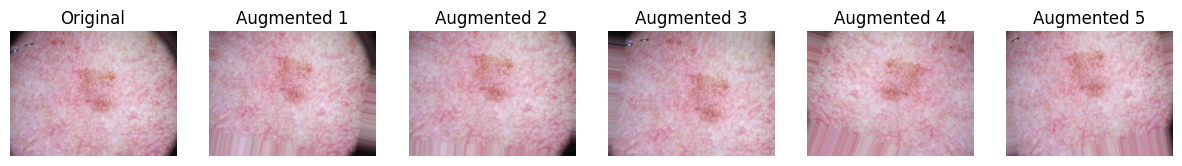

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

import numpy as np
import matplotlib.pyplot as plt

# Choose one image from the training directory
img_path = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0033866.jpg")

# Load the image
img = plt.imread(img_path)

# Reshape the image to a 4D tensor with shape (1, height, width, channels)
img_tensor = np.expand_dims(img, axis=0)

# Generate augmented images
num_augmented_images = 5
fig, axes = plt.subplots(1, num_augmented_images + 1, figsize=(15, 5))

# Plot the original image
axes[0].imshow(img)
axes[0].set_title('Original')
axes[0].axis('off')

# Plot the augmented images
for i in range(1, num_augmented_images + 1):
    augmented_img = datagen.random_transform(img_tensor[0])
    axes[i].imshow(augmented_img)
    axes[i].set_title(f'Augmented {i}')
    axes[i].axis('off')

plt.show()


### Todo:
### Create the model, compile and train the model


In [22]:
input_shape = (180,180,3)
num_classes = 9

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Compiling the model

In [23]:
## Your code goes here
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model.fit(
  train_generator,
  validation_data=test_generator,
  epochs=epochs,
  batch_size=batch_size,
  shuffle=True
)

Epoch 1/20
70/70 [==============================] - 53s 701ms/step - loss: 50.3899 - accuracy: 0.2608 - val_loss: 58.8713 - val_accuracy: 0.1356
Epoch 2/20
70/70 [==============================] - 45s 643ms/step - loss: 21.8513 - accuracy: 0.2331 - val_loss: 68.7722 - val_accuracy: 0.1356
Epoch 3/20
70/70 [==============================] - 48s 685ms/step - loss: 13.3191 - accuracy: 0.2617 - val_loss: 52.3226 - val_accuracy: 0.1356
Epoch 4/20
70/70 [==============================] - 45s 644ms/step - loss: 8.5731 - accuracy: 0.2724 - val_loss: 37.2606 - val_accuracy: 0.1356
Epoch 5/20
70/70 [==============================] - 50s 715ms/step - loss: 5.9112 - accuracy: 0.2756 - val_loss: 23.5295 - val_accuracy: 0.1356
Epoch 6/20
70/70 [==============================] - 45s 638ms/step - loss: 4.3338 - accuracy: 0.2751 - val_loss: 18.6891 - val_accuracy: 0.1356
Epoch 7/20
70/70 [==============================] - 48s 692ms/step - loss: 3.4203 - accuracy: 0.2809 - val_loss: 11.0420 - val_accura

### Visualizing the results

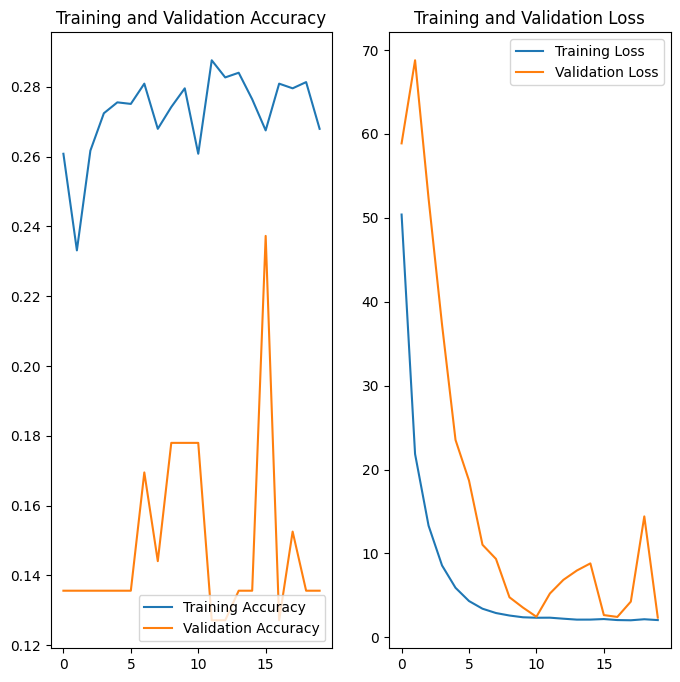

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
loss, accuracy = model.evaluate(train_generator, verbose=1)
loss_v, accuracy_v = model.evaluate(test_generator, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ", accuracy_v)
print("Loss: ", loss)
print("Validation Loss", loss_v)


4/4 [==============================] - 7s 1s/step - loss: 2.3567 - accuracy: 0.1356
Accuracy:  0.20634211599826813
Validation Accuracy:  0.1355932205915451
Loss:  2.191030263900757
Validation Loss 2.3567142486572266


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Observation: Accuracy has reduced, overfitting still exists

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

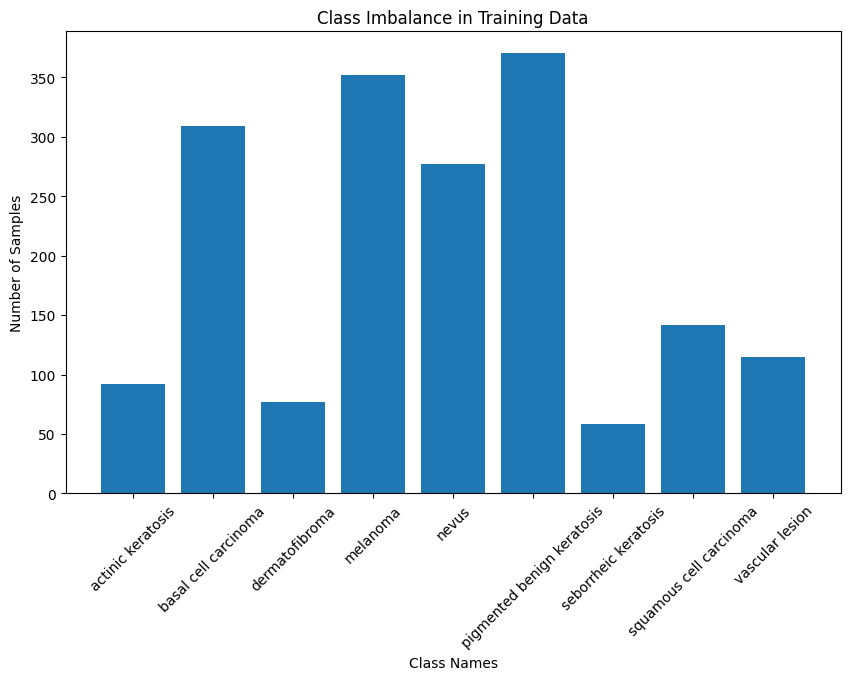

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize an array to store the count of samples for each class
class_counts = np.zeros(len(class_names))

# Iterate over the training dataset to count the samples for each class
for images, labels in train_ds:
    class_counts += np.sum(labels.numpy(), axis=0)

# Plot the class imbalance
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts)
plt.title('Class Imbalance in Training Data')
plt.xlabel('Class Names')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#####  Answer: Seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
##### Answer: Pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
import Augmentor

path_to_training_dataset = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset / i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D8FABDA5150>: 100%|██████████| 500/500 [00:15<00:00, 32.15 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D8FAB202F20>: 100%|██████████| 500/500 [00:15<00:00, 32.59 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D8FAB36BE50>: 100%|██████████| 500/500 [00:15<00:00, 32.30 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7D9020128550>: 100%|██████████| 500/500 [01:31<00:00,  5.44 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D9028300130>: 100%|██████████| 500/500 [01:18<00:00,  6.37 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D8FABD422F0>: 100%|██████████| 500/500 [00:15<00:00, 31.82 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D90101F7DC0>: 100%|██████████| 500/500 [00:37<00:00, 13.26 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D8FAB374280>: 100%|██████████| 500/500 [00:15<00:00, 31.91 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D9020174280>: 100%|██████████| 500/500 [00:15<00:00, 32.07 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
import os
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032203.jpg_e0b745e6-11d8-4c7e-9872-ab498d80384d.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0024923.jpg_002fd74f-ef14-4e1c-8203-c8a295e00427.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029634.jpg_fb6778d0-2aa5-4d10-9a11-75afd845909b.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029462.jpg_0993b1bb-7f3c-4e96-920c-fcc2e2c0a858.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029567.jpg_afb407c5-fd1f-4dba-bb87-69d9

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [34]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [36]:
new_df['Label'].value_counts()

Label
squamous cell carcinoma       500
seborrheic keratosis          500
dermatofibroma                500
melanoma                      500
pigmented benign keratosis    500
vascular lesion               500
nevus                         500
actinic keratosis             500
basal cell carcinoma          500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [38]:
data_dir_train=pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [40]:
## your code goes here

input_shape = (180,180,3)
num_classes = 9

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [41]:
## your code goes here
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [42]:

## Your code goes here, use 50 epochs.

epochs = 50

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=batch_size,
  shuffle=True
)

Epoch 1/50
169/169 [==============================] - 45s 229ms/step - loss: 25.5214 - accuracy: 0.2467 - val_loss: 61.0656 - val_accuracy: 0.1359
Epoch 2/50
169/169 [==============================] - 34s 199ms/step - loss: 8.8815 - accuracy: 0.2878 - val_loss: 12.3400 - val_accuracy: 0.2049
Epoch 3/50
169/169 [==============================] - 37s 213ms/step - loss: 4.4845 - accuracy: 0.2938 - val_loss: 4.0519 - val_accuracy: 0.3326
Epoch 4/50
169/169 [==============================] - 35s 199ms/step - loss: 3.7163 - accuracy: 0.2967 - val_loss: 3.4272 - val_accuracy: 0.3615
Epoch 5/50
169/169 [==============================] - 40s 233ms/step - loss: 3.0952 - accuracy: 0.3286 - val_loss: 3.6455 - val_accuracy: 0.3578
Epoch 6/50
169/169 [==============================] - 36s 207ms/step - loss: 2.9580 - accuracy: 0.3448 - val_loss: 2.3685 - val_accuracy: 0.4232
Epoch 7/50
169/169 [==============================] - 35s 198ms/step - loss: 2.4887 - accuracy: 0.3405 - val_loss: 2.4759 - val

#### **Todo:**  Visualize the model results

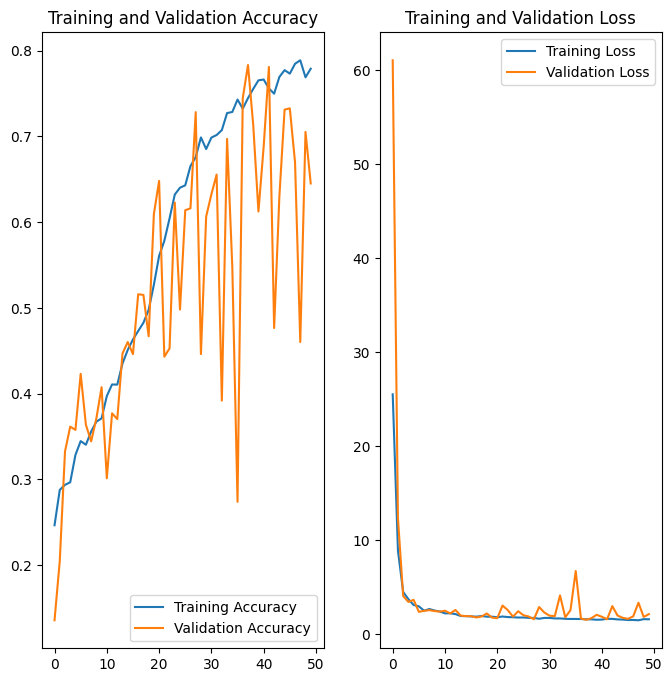

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [44]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 5s 96ms/step - loss: 2.1258 - accuracy: 0.6451
Accuracy:  0.7581602334976196
Validation Accuracy:  0.645137369632721
Loss:  1.7003676891326904
Validation Loss 2.125840187072754


In [46]:
### Observation: After rebalancing got rid of overfit of data and also accuracy has improved